In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'/Users/jakubzmujdzin/Desktop/repo/luna-nlp-paper/predictions_for_thresholds_0.005_to_0.3.csv')

In [3]:
tmp = []
for threshold in np.linspace(0.005, 0.3, num=60):
    thrsh_df = df[round(df.threshold, 3) == round(threshold, 3)]
    thrsh_df = thrsh_df.sort_values(by='accuracy', ascending=False)
    tmp.append(thrsh_df.iloc[0,].values)

In [4]:
best_preds_for_each_threshold = pd.DataFrame(tmp, columns=df.columns)
best_preds_for_each_threshold = best_preds_for_each_threshold[best_preds_for_each_threshold.threshold <= 0.25]

/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

Text(0.0075, 0.81, 'Bert')

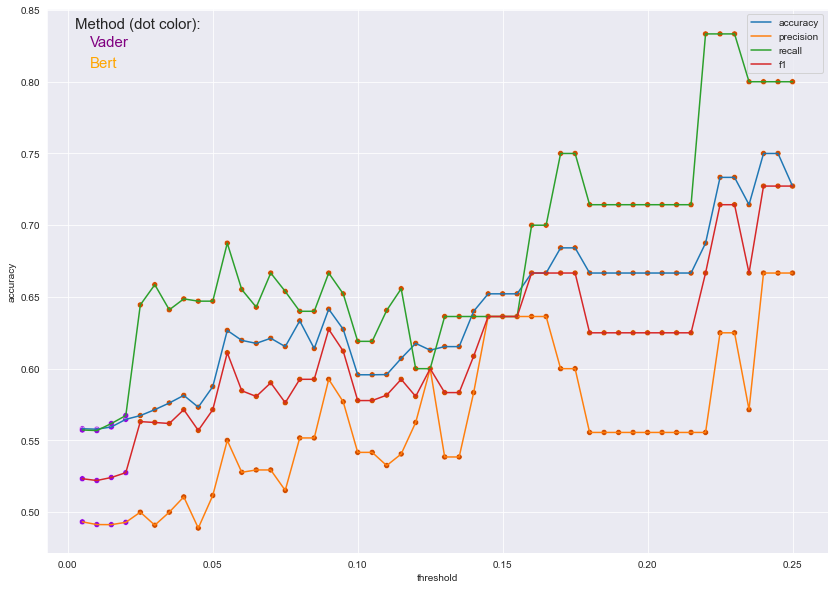

In [5]:
plt.figure(figsize=(14, 10))
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score)
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy, hue=best_preds_for_each_threshold.method, palette='gnuplot')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision, hue=best_preds_for_each_threshold.method, palette='gnuplot')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall, hue=best_preds_for_each_threshold.method, palette='gnuplot')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score, hue=best_preds_for_each_threshold.method, palette='gnuplot')
plt.legend(('accuracy', 'precision', 'recall', 'f1'))
plt.text(0.0025, 0.8375, 'Method (dot color):', fontsize=15)
plt.text(0.0075, 0.825, 'Vader', fontsize=15, color='purple')
plt.text(0.0075, 0.81, 'Bert', fontsize=15, color='orange')